<a href="https://colab.research.google.com/github/IdrissaIyamuremye/pytorch/blob/main/Porject_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ta-lib --quiet
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, mean_absolute_error

import talib as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
from tqdm.auto import tqdm, trange
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

#Step 1:  Loading Data

In [2]:
start_date = "2010-01-01" #Starting data
end_date = "2026-01-01"
ticker = "AAPL"
stock = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
stock.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [4]:
stock_copy = stock.copy()
stock_copy.columns = stock_copy.columns.droplevel(1)

stock_copy

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.418383,6.433079,6.369498,6.400988,493729600
2010-01-05,6.429480,6.465769,6.395590,6.436078,601904800
2010-01-06,6.327211,6.454973,6.320613,6.429480,552160000
2010-01-07,6.315514,6.358101,6.269627,6.350604,477131200
2010-01-08,6.357501,6.358101,6.269928,6.307116,447610800
...,...,...,...,...,...
2025-12-24,273.809998,275.429993,272.200012,272.339996,17910600
2025-12-26,273.399994,275.369995,272.859985,274.160004,21521800
2025-12-29,273.760010,274.359985,272.350006,272.690002,23715200


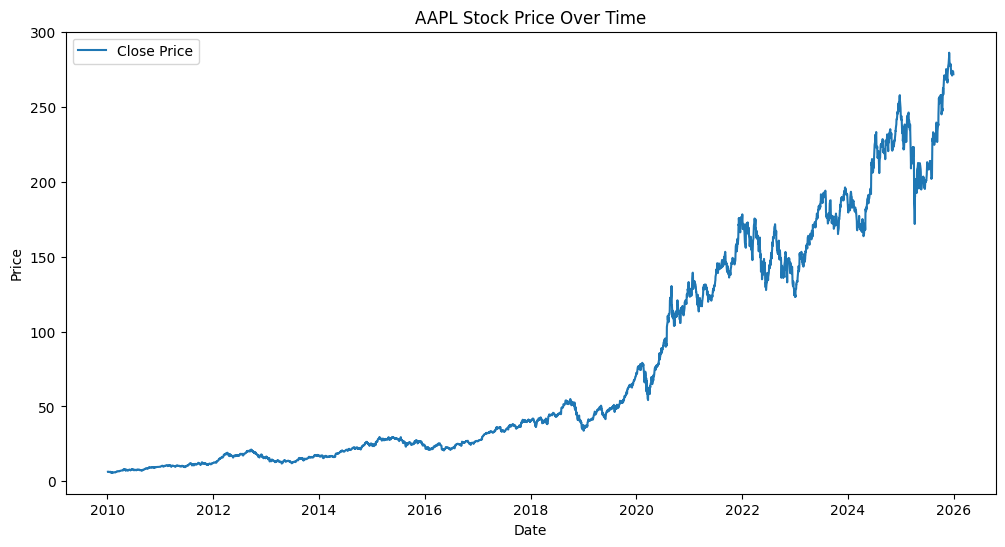

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(stock_copy.index, stock_copy['Close'], label='Close Price')
plt.title(f'{ticker} Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
df = pd.DataFrame(index=stock_copy.index)

df["Open_returns"]   = np.log(stock_copy["Open"]   / stock_copy["Open"].shift(1))
df["Low_returns"]    = np.log(stock_copy["Low"]    / stock_copy["Low"].shift(1))
df["High_returns"]   = np.log(stock_copy["High"]   / stock_copy["High"].shift(1))
df["Volume_returns"] = np.log(stock_copy["Volume"] / stock_copy["Volume"].shift(1))
df["Close_returns"]  = np.log(stock_copy["Close"]  / stock_copy["Close"].shift(1))

df.dropna(inplace=True)
df


,Open_returns,Low_returns,High_returns,Volume_returns,Close_returns
Date,,,,,
2010-01-05,0.005467,0.004088,5.068774e-03,0.198111,0.001727
2010-01-06,-0.001026,-0.011793,-1.671173e-03,-0.086261,-0.016034
2010-01-07,-0.012344,-0.008099,-1.512100e-02,-0.146046,-0.001850
2010-01-08,-0.006871,0.000048,-3.184089e-08,-0.063867,0.006626
2010-01-11,0.011818,-0.002922,4.705994e-03,0.032138,-0.008860
...,...,...,...,...,...
2025-12-24,0.005523,0.009746,1.069487e-02,-0.503800,0.005310
2025-12-26,0.006661,0.002422,-2.178561e-04,0.183674,-0.001499
2025-12-29,-0.005376,-0.001871,-3.674571e-03,0.097050,0.001316


In [7]:
train_end = "2020-12-31"
val_end   = "2022-12-31"
train_size = df.loc[:train_end].shape[0]
val_size   = df.loc[train_end:val_end].shape[0]

In [8]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled

array([[0.50773721, 0.65613797, 0.52687651, 0.5505682 , 0.49740515],
       [0.48678551, 0.6100112 , 0.49325165, 0.47111756, 0.43404452],
       [0.45026196, 0.62073878, 0.42615191, 0.4544143 , 0.48464184],
       ...,
       [0.47274625, 0.63883   , 0.48325691, 0.52233273, 0.49593723],
       [0.49151505, 0.64351711, 0.49649492, 0.47601053, 0.48237069],
       [0.49305117, 0.63860444, 0.49430281, 0.55368984, 0.47527013]])

In [9]:
def create_aapl_data(inputs, window_size):
    X, y = [], []
    for i in range(window_size, len(inputs)):
        X.append(inputs[i - window_size : i, :-1])  # all columns except last
        y.append(inputs[i, -1])                     # last column as target
    return np.array(X), np.array(y)


In [10]:
window_size = 60

X, y = create_aapl_data(df_scaled, window_size)
X.shape, y.shape



((3963, 60, 4), (3963,))

In [11]:
X_train_np, y_train_np = X[:train_size], y[:train_size]
X_val_np, y_val_np = X[train_size:train_size+val_size], y[train_size:train_size + val_size]
X_test_np, y_test_np = X[:val_size], y[:val_size]
X_train_np.shape, y_train_np.shape, X_val_np.shape, y_val_np.shape


((2768, 60, 4), (2768,), (504, 60, 4), (504,))

In [12]:
#Numpy to Tensor
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_val   = torch.tensor(X_val_np,   dtype=torch.float32)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32)

y_train = torch.tensor(y_train_np, dtype=torch.float32)
y_val   = torch.tensor(y_val_np,   dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


(torch.Size([2768, 60, 4]),
 torch.Size([2768]),
 torch.Size([504, 60, 4]),
 torch.Size([504]),
 torch.Size([504, 60, 4]),
 torch.Size([504]))

In [13]:
# Ensure y is 2D column vector
y_train = y_train.view(-1, 1)
y_val   = y_val.view(-1, 1)
y_test  = y_test.view(-1, 1)

# X is already 2D [num_samples, num_features]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


(torch.Size([2768, 60, 4]),
 torch.Size([2768, 1]),
 torch.Size([504, 60, 4]),
 torch.Size([504, 1]),
 torch.Size([504, 60, 4]),
 torch.Size([504, 1]))

In [14]:
#Creating dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

#Bach-size
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

#Step 3: Modeling

In [15]:

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.Q = nn.Linear(hidden_dim, hidden_dim)
        self.K = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        # x: (batch, timesteps, hidden_dim)
        Q = self.Q(x)
        K = self.K(x)
        V = self.V(x)

        attn_scores = torch.bmm(Q, K.transpose(1, 2))
        attn_scores = attn_scores / math.sqrt(self.hidden_dim)

        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.bmm(attn_weights, V)

        # Use last timestep representation
        context = context[:, -1, :]

        return context, attn_weights


In [16]:


class LSTMRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 1)  # output a single value per sequence

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the last hidden state for regression
        last_hidden = lstm_out[:, -1, :]      # (batch, hidden_size)
        out = self.dropout(last_hidden)
        out = self.fc(out)                    # (batch, 1)
        return out


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
model = LSTMRegression(4, 64, 1).to(device)


In [19]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5)


In [20]:
epochs = 60
loss_train = []
loss_val = []

for epoch in trange(epochs):

    # -------- Training --------
    model.train()
    train_loss_epoch = 0.0
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred= model(X_batch)


        loss = loss_fn(y_batch, y_pred)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

    train_loss_epoch /= len(train_dataloader)
    loss_train.append(train_loss_epoch)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss_epoch:.4f}")

    # -------- Validation --------
    model.eval()
    val_loss_epoch = 0.0

    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            X_val = X_val.to(device)

            y_val = y_val.to(device)

            y_pred= model(X_val)
            val_loss = loss_fn(y_val, y_pred)

            val_loss_epoch += val_loss.item()

    val_loss_epoch /= len(val_dataloader)
    loss_val.append(val_loss_epoch)

    print(f"Epoch {epoch+1} | Val Loss: {val_loss_epoch:.4f}")


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.1733
Epoch 1 | Val Loss: 0.1650
Epoch 2 | Train Loss: 0.1583
Epoch 2 | Val Loss: 0.1503
Epoch 3 | Train Loss: 0.1439
Epoch 3 | Val Loss: 0.1357
Epoch 4 | Train Loss: 0.1289
Epoch 4 | Val Loss: 0.1212
Epoch 5 | Train Loss: 0.1143
Epoch 5 | Val Loss: 0.1065
Epoch 6 | Train Loss: 0.0997
Epoch 6 | Val Loss: 0.0916
Epoch 7 | Train Loss: 0.0845
Epoch 7 | Val Loss: 0.0766
Epoch 8 | Train Loss: 0.0694
Epoch 8 | Val Loss: 0.0614
Epoch 9 | Train Loss: 0.0544
Epoch 9 | Val Loss: 0.0465
Epoch 10 | Train Loss: 0.0396
Epoch 10 | Val Loss: 0.0323
Epoch 11 | Train Loss: 0.0264
Epoch 11 | Val Loss: 0.0200
Epoch 12 | Train Loss: 0.0155
Epoch 12 | Val Loss: 0.0110
Epoch 13 | Train Loss: 0.0087
Epoch 13 | Val Loss: 0.0063
Epoch 14 | Train Loss: 0.0058
Epoch 14 | Val Loss: 0.0048
Epoch 15 | Train Loss: 0.0051
Epoch 15 | Val Loss: 0.0046
Epoch 16 | Train Loss: 0.0049
Epoch 16 | Val Loss: 0.0046
Epoch 17 | Train Loss: 0.0049
Epoch 17 | Val Loss: 0.0046
Epoch 18 | Train Loss: 0.0051
Ep

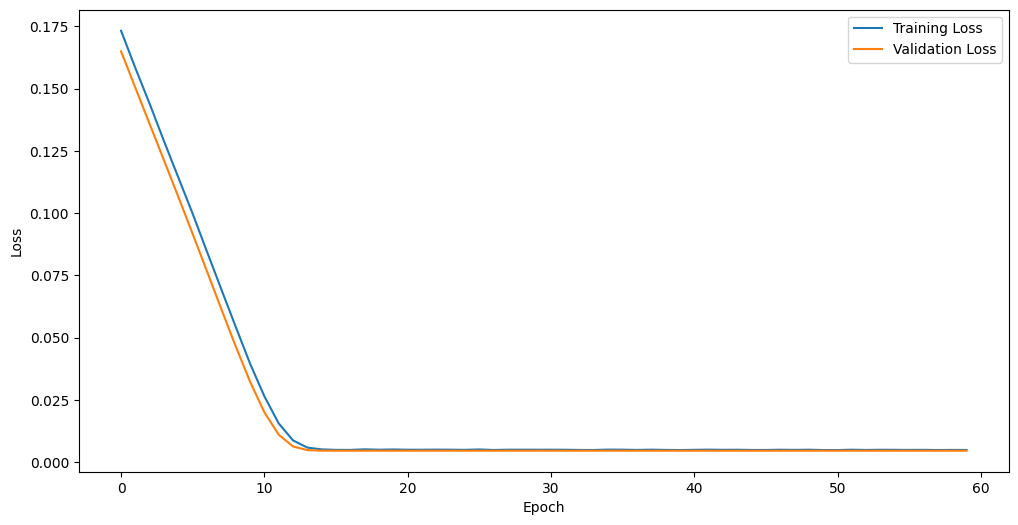

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), loss_train, label='Training Loss')
plt.plot(range(epochs), loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), "model_lstm_attn.pth") #Saving Model

In [23]:
model = LSTMRegression(4, 64, 1)
model.load_state_dict(torch.load("model_lstm_attn.pth"))
model.to(device)
model.eval()

predictions = []
true_values = []
attention_weights_list = []

with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred= model(X_batch)

        predictions.append(y_pred.cpu())
        true_values.append(y_batch.cpu())

        # handle tuple of attention weights
        #attn1_cpu = attn_weights[0].cpu()
        #attn2_cpu = attn_weights[1].cpu()
        #attention_weights_list.append((attn1_cpu, attn2_cpu))

# concatenate tensors
predictions = torch.cat(predictions, dim=0).numpy().flatten()
true_values = torch.cat(true_values, dim=0).numpy().flatten()

# attention separately
#attn1_all = torch.cat([w[0] for w in attention_weights_list], dim=0)
#attn2_all = torch.cat([w[1] for w in attention_weights_list], dim=0)

# inverse transform if needed




# Fit scaler only on the target column
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df[['Close_returns']].values)  # keep as 2D

# ... train your model on y_scaled ...

# later, inverse transform predictions
y_pred_original = scaler_y.inverse_transform(predictions.reshape(-1,1)).flatten()
y_true_original = scaler_y.inverse_transform(true_values.reshape(-1,1)).flatten()


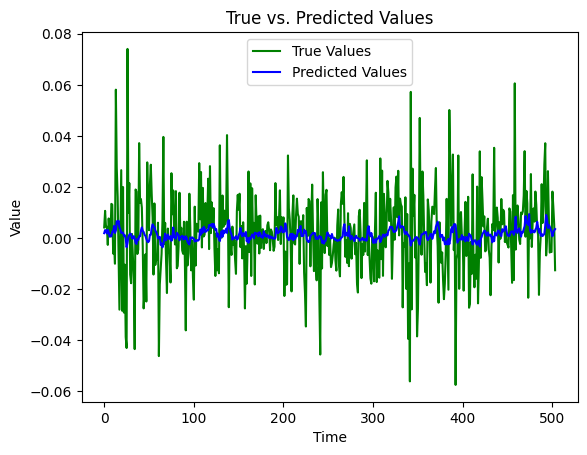

In [24]:
#plt.figure(figsize=(12, 6))
plt.plot(y_true_original, label='True Values', color="green")
plt.plot(y_pred_original, label='Predicted Values', color="blue")
plt.legend()
plt.title('True vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [26]:


rmse = mean_squared_error(y_true_original, y_pred_original)
mae  = mean_absolute_error(y_true_original, y_pred_original)
r2_score_ = r2_score(y_true_original, y_pred_original)
print(f"Test RMSE: {rmse:.4f} || MAE: {mae:.4f} || r2_score: {r2_score_: .4f}")


Test RMSE: 0.0003 || MAE: 0.0123 || r2_score: -0.0188
